In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight



=== Distribución total de imágenes (Train + Val + Test, Total: 30219) ===
 Emoción  Conteo Total  Proporción (%)
   angry          4953       16.390350
   happy          8989       29.746186
 neutral          6198       20.510275
     sad          6077       20.109865
surprise          4002       13.243324


C:\Users\mcash\AppData\Local\Temp\ipykernel_15476\1614645858.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Emoción', y='Conteo Total', data=df, palette='coolwarm')


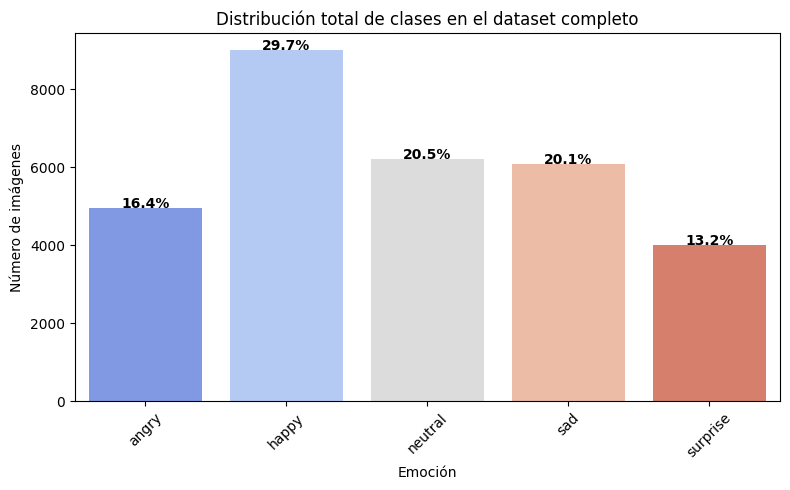

In [ ]:
def total_class_distribution(train_dir, val_dir, test_dir):
    # Datos
    datasets = [train_dir, val_dir, test_dir]
    
    counts = {}
    
    for folder in datasets:
        for emotion in os.listdir(folder):
            emotion_path = os.path.join(folder, emotion)
            if os.path.isdir(emotion_path):
                counts[emotion] = counts.get(emotion, 0) + len(os.listdir(emotion_path))
    
    df = pd.DataFrame({
        'Emoción': list(counts.keys()),
        'Conteo Total': list(counts.values())
    }).sort_values('Emoción')
    
    total = df['Conteo Total'].sum()
    df['Proporción (%)'] = df['Conteo Total'] / total * 100
    
    print(f"\n=== Distribución total de imágenes (Train + Val + Test, Total: {total}) ===")
    print(df.to_string(index=False))
    
    # Gráfico
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x='Emoción', y='Conteo Total', data=df, palette='coolwarm')
    for i, row in df.iterrows():
        ax.text(i, row['Conteo Total'] + 1, f"{row['Proporción (%)']:.1f}%", ha='center', weight='bold')
    plt.title('Distribución total de clases en el dataset completo')
    plt.ylabel('Número de imágenes')
    plt.xlabel('Emoción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Uso:
total_class_distribution('emotion_dataset/train', 'emotion_dataset/validation', 'emotion_dataset/test')


In [ ]:
# Definición del modelo

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 emociones
])


c:\Users\mcash\anaconda3\envs\VC_MCH_PL5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Aumentación de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Solo normalización para validación y test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    'emotion_dataset/train',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    'emotion_dataset/validation',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 21151 images belonging to 5 classes.
Found 4530 images belonging to 5 classes.


In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Obtener etiquetas de entrenamiento
y_train = train_generator.classes
classes = np.unique(y_train)

# Calcular pesos
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

# Entrenamiento
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    class_weight=class_weights
)


Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3007 - loss: 1.6258 - val_accuracy: 0.2280 - val_loss: 2.2544
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.3688 - loss: 1.4533 - val_accuracy: 0.4744 - val_loss: 1.2811
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4053 - loss: 1.3876 - val_accuracy: 0.4525 - val_loss: 1.2755
Epoch 4/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4267 - loss: 1.3460 - val_accuracy: 0.5166 - val_loss: 1.1671
Epoch 5/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.4537 - loss: 1.3045 - val_accuracy: 0.5194 - val_loss: 1.1676
Epoch 6/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4759 - loss: 1.2570 - val_accuracy: 0.4987 - val_loss: 1.1984
Epoch 7/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4938 - loss: 1.2285 - val_accuracy: 0.5093 - val_loss: 1.1887
Epoch 8/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.5117 - loss: 1.1928 - 

In [15]:
# Después de entrenar
model.save('emotion_model.h5')  # formato HDF5
# o
model.save('emotion_model.keras')  # nuevo formato recomendado

In [ ]:
# GRÁFICA DE LOSS (train vs validation)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de la Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# GRÁFICA DE ACCURACY (train vs validation)
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolución de Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Found 4538 images belonging to 5 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6754 - loss: 0.8566
Precisión en test: 67.54%


NameError: name 'history' is not defined

<Figure size 800x500 with 0 Axes>

Found 4538 images belonging to 5 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6754 - loss: 0.8566
Pérdida en test: 0.8566
Precisión en test: 67.54%

Nombres de las clases: ['angry', 'happy', 'neutral', 'sad', 'surprise']
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


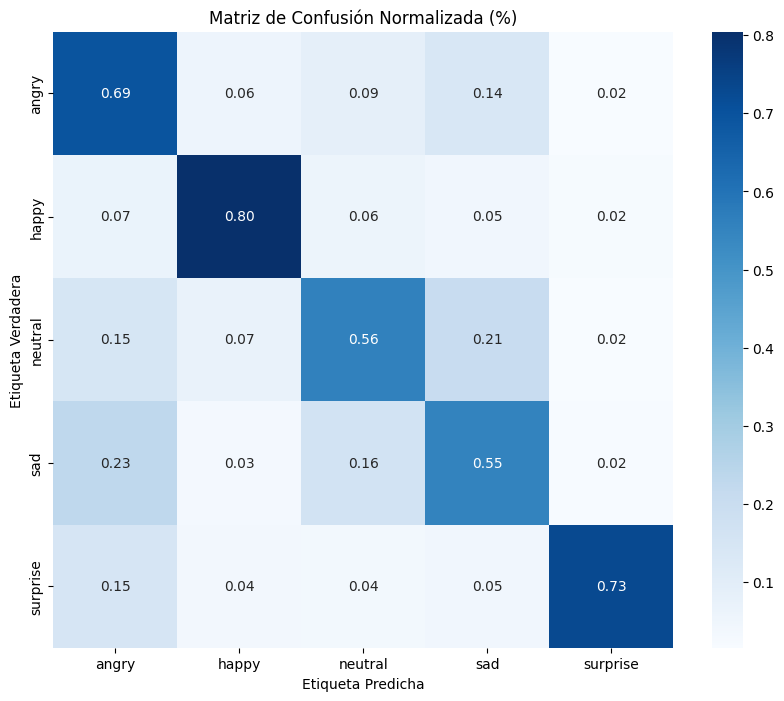

In [ ]:
model = load_model('emotion_model.h5')

test_generator = val_test_datagen.flow_from_directory(
    'emotion_dataset/test',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Pérdida en test: {test_loss:.4f}')
print(f'Precisión en test: {test_acc*100:.2f}%')

class_names = list(test_generator.class_indices.keys())
print(f"\nNombres de las clases: {class_names}")

true_labels = test_generator.classes

test_generator.reset()
predictions_probs = model.predict(test_generator)

predicted_labels = np.argmax(predictions_probs, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Normalizar por filas (suma de cada clase verdadera)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión Normalizada (%)')
plt.show()


In [16]:
labels = [name for name, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1])]

# Cargar filtros por emoción
filters = {}
for label in labels:
    path_png = os.path.join("filters", f"{label}.png")
    path_jpg = os.path.join("filters", f"{label}.jpg")
    
    if os.path.exists(path_png):
        filters[label] = cv2.imread(path_png, cv2.IMREAD_UNCHANGED)
    elif os.path.exists(path_jpg):
        filters[label] = cv2.imread(path_jpg, cv2.IMREAD_UNCHANGED)
    else:
        print(f"[ADVERTENCIA] No existe filtro para {label}")
        filters[label] = None

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

print("Presiona 'ESC' para salir...")

# Emoción inicial por defecto
current_emotion = None

def prepare_filter_image(filter_img, height):
    """Redimensiona el filtro manteniendo proporción y sin alfa"""
    if filter_img is None:
        return np.zeros((height, height, 3), dtype=np.uint8)

    # Convertir PNG transparente a BGR
    if filter_img.shape[2] == 4:
        filter_img = cv2.cvtColor(filter_img, cv2.COLOR_BGRA2BGR)

    h, w = filter_img.shape[:2]
    scale = height / h
    new_w = int(w * scale)
    img_resized = cv2.resize(filter_img, (new_w, height))
    return img_resized


while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Cámara
    for (x, y, w, h) in faces[:1]:
        face_roi = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, (48, 48))
        face_norm = face_resized.astype('float32') / 255.0
        face_input = np.expand_dims(face_norm, axis=-1)
        face_input = np.expand_dims(face_input, axis=0)

        pred_probs = model.predict(face_input, verbose=0)
        pred_class = np.argmax(pred_probs)
        emotion = labels[pred_class]
        confidence = pred_probs[0][pred_class]

        current_emotion = emotion

        cv2.putText(
            frame,
            f"{emotion} ({confidence*100:.1f}%)",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 255, 0),
            2
        )

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)

    # Zona emoji
    frame_h, frame_w = frame.shape[:2]

    if current_emotion is not None:
        filter_img = prepare_filter_image(filters[current_emotion], frame_h)
    else:
        filter_img = np.zeros((frame_h, frame_h, 3), dtype=np.uint8)

    # Combinar ambas imágenes en una sola ventana
    combined = np.hstack((frame, filter_img))

    cv2.imshow("Detección de Emoción | Filtro", combined)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


Presiona 'ESC' para salir...


In [ ]:
import cv2
import numpy as np
import os

# Cargar filtros PNG
filters = {}
for name in ['hat', 'glasses', 'scarf']:
    path = os.path.join("filters", f"{name}.png")
    if os.path.exists(path):
        filters[name] = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    else:
        filters[name] = None
        print(f"[ADVERTENCIA] No existe filtro para {name}")

# Funciones de filtros
def overlay_alpha(img, overlay, x, y):
    h, w = overlay.shape[:2]
    x = int(x)
    y = int(y)
    if x + w <= 0 or y + h <= 0 or x >= img.shape[1] or y >= img.shape[0]:
        return img
    x1 = max(x, 0)
    y1 = max(y, 0)
    x2 = min(x + w, img.shape[1])
    y2 = min(y + h, img.shape[0])
    overlay_x1 = x1 - x
    overlay_y1 = y1 - y
    overlay_x2 = overlay_x1 + (x2 - x1)
    overlay_y2 = overlay_y1 + (y2 - y1)
    if overlay_x2 - overlay_x1 <= 0 or overlay_y2 - overlay_y1 <= 0:
        return img
    if overlay.shape[2] == 4:
        alpha = overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2, 3] / 255.0
        for c in range(3):
            img[y1:y2, x1:x2, c] = (
                alpha * overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2, c] +
                (1 - alpha) * img[y1:y2, x1:x2, c]
            )
    else:
        img[y1:y2, x1:x2] = overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2]
    return img

def transform_filter(filt, width, height, angle):
    filt_resized = cv2.resize(filt, (int(width), int(height)))
    M = cv2.getRotationMatrix2D((int(width)//2, int(height)//2), float(angle), 1.0)
    return cv2.warpAffine(filt_resized, M, (int(width), int(height)),
                          flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

# Cámara y detector de caras
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        eye_y = int(y + 0.35 * h)
        eye_center_x = x + w // 2
        angle = 0

        # Bufanda
        if filters['scarf'] is not None:
            scarf_w = int(w * 1.1)
            scarf_h = int(filters['scarf'].shape[0] * (scarf_w / filters['scarf'].shape[1]))
            scarf_img = transform_filter(filters['scarf'], scarf_w, scarf_h, angle)
            scarf_y = y + h + 10
            scarf_x = eye_center_x - scarf_w // 2
            frame = overlay_alpha(frame, scarf_img, scarf_x, scarf_y)

        # Gafas
        if filters['glasses'] is not None:
            glass_w = int(w * 1.0)
            glass_h = int(filters['glasses'].shape[0] * (glass_w / filters['glasses'].shape[1]))
            glasses_img = transform_filter(filters['glasses'], glass_w, glass_h, angle)
            frame = overlay_alpha(frame, glasses_img, eye_center_x - glass_w//2, eye_y - glass_h//2)

        # Sombrero
        if filters['hat'] is not None:
            hat_w = int(w * 1.2)
            hat_h = int(filters['hat'].shape[0] * (hat_w / filters['hat'].shape[1]))
            hat_img = transform_filter(filters['hat'], hat_w, hat_h, angle)
            frame = overlay_alpha(frame, hat_img, eye_center_x - hat_w//2, y - hat_h + 40)

    cv2.imshow("Probador virtual fijo", frame)

    if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
        break

cap.release()
cv2.destroyAllWindows()
